<a href="https://colab.research.google.com/github/DoryAbelman/CARTE-ML-Program/blob/main/lab_4_1_convolutional_neural_networks_dory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions

In this lab, we'll look in detail at convolutions and how they can be used to process images.

### Reading and opening images

We'll use the `skimage` library to read and process images. It's a library dedicated to image processing, which is part of the `scikit-learn` family.

In [1]:
# Check if the packages are installed, if not install them.
# Note - if you are working locally, you may want to comment this section out
# ...and use your preferred method of installing packages.
import importlib

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        !pip install {package}

for package in ["matplotlib", "numpy", "sklearn", "pandas", "tensorflow", "scikit-image"]:
    install_if_missing(package)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread

In [3]:
# Helper function to download images from our GitHub repo

def download_image(image_name):
    url = "https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/notebooks/images/" + image_name
    import requests
    r = requests.get(url)
    with open(image_name, 'wb') as f:
        f.write(r.content)

sample image shape:  (600, 600, 3)


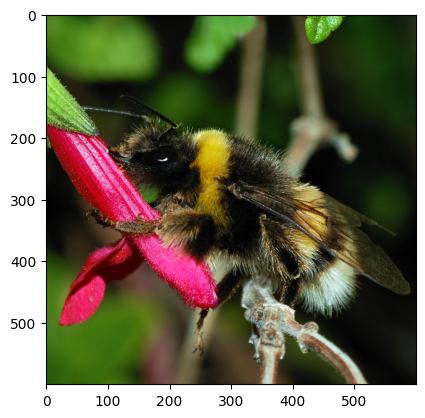

In [4]:
download_image("bumblebee.png")
sample_image = imread("bumblebee.png")
sample_image= sample_image.astype("float32")

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

### A simple convolution filter

Before we start working on training any models, let's look at applying a convolution filter to an image. We'll use the `Conv2D` layer from Keras to do this.

In [5]:
from tensorflow.keras.layers import Conv2D

In [6]:
conv = Conv2D(filters=3, kernel_size=(5, 5), padding="same",
              input_shape=(None, None, 3))

Remember: in Keras, `None` is used as a marker for tensor dimensions with dynamic size. In this case `batch_size`, `width` and `height` are all dynamic: they can depend on the input. This is a neat feature of convolutional neural networks: the same model can be used to process images of any size, because all we have to do is slide the convolutional filter across the image as much as necessary.

In [7]:
sample_image.shape

(600, 600, 3)

In [8]:
img_in = np.expand_dims(sample_image, 0)
img_in.shape

(1, 600, 600, 3)

In [9]:
img_out = conv(img_in) # Apply the convolutional filter

The output is a tensorflow Eager Tensor - a special data structure that is used to represent the result of operations in TensorFlow. It is not a numpy array, but it can be converted to one using the `.numpy()` method:

In [10]:
np_img_out = img_out[0].numpy()
print(type(np_img_out))
print(np_img_out.shape)

<class 'numpy.ndarray'>
(600, 600, 3)


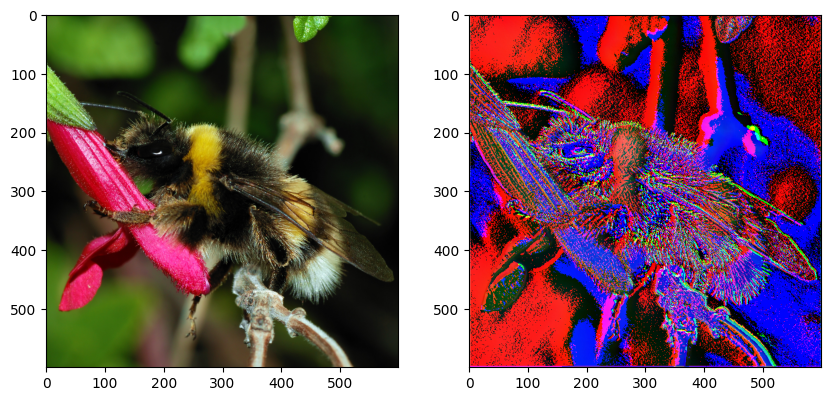

In [11]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(np_img_out.astype('uint8'));

As we can see, our convolutional filter was initialized randomly, so our output doesn't contain any specific meaning. Each pixel is a random combination of the pixels in the input image, in a 5x5 window.

Let's instead take a look at a convolutional feature with a clear purpose. We can build a kernel ourselves, by defining a function which will be passed to `Conv2D` Layer.
We'll create an array with 1/25 for filters, with each channel seperated. Before you move to the next cell, can you guess what this filter will do?

In [12]:
def my_kernel(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

Now we can use this function to initialize a `Conv2D` layer:

In [13]:
conv = Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_kernel)

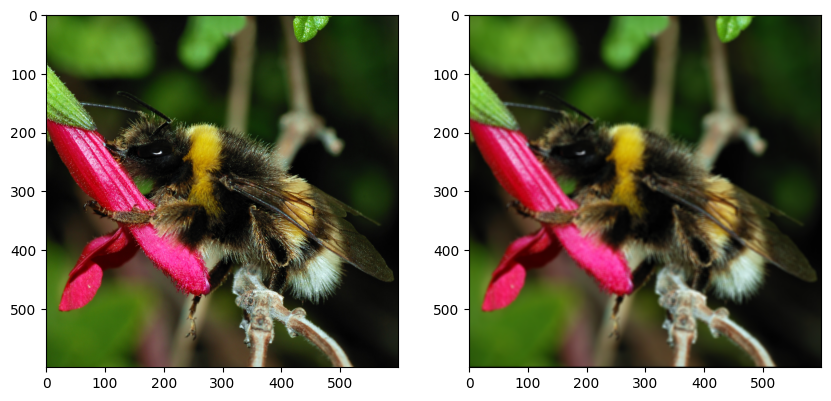

In [14]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))

img_out = conv(img_in)
np_img_out = img_out[0].numpy()
ax1.imshow(np_img_out.astype('uint8'));

Hopefully you can tell what this filter does!

**Exercise**
- There are a number of settings when we define our Conv2D layer. Try changing the following parameters to get a sense of how they impact the result:
- kernel_size: try different sizes
- padding: try 'valid' instead of 'same' (hint: this may change the size of the output)

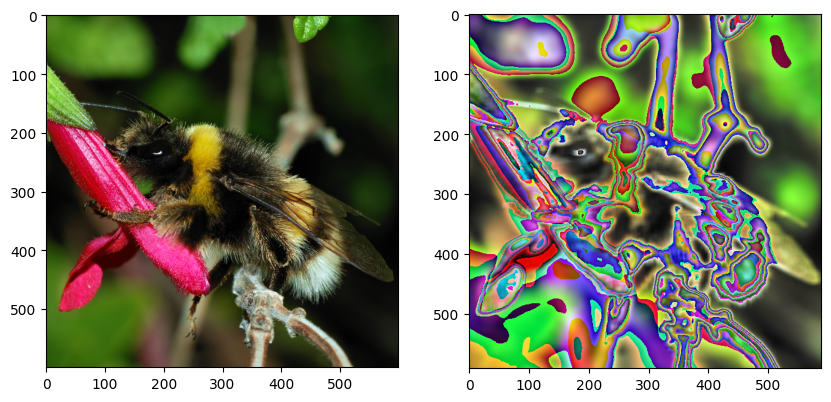

In [15]:
# Your code here
conv2 = Conv2D(filters=3, kernel_size=(9, 12), padding="valid",
           input_shape=(None, None, 3), kernel_initializer=my_kernel)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))

img_out = conv2(img_in)
np_img_out = img_out[0].numpy()
ax1.imshow(np_img_out.astype('uint8'));

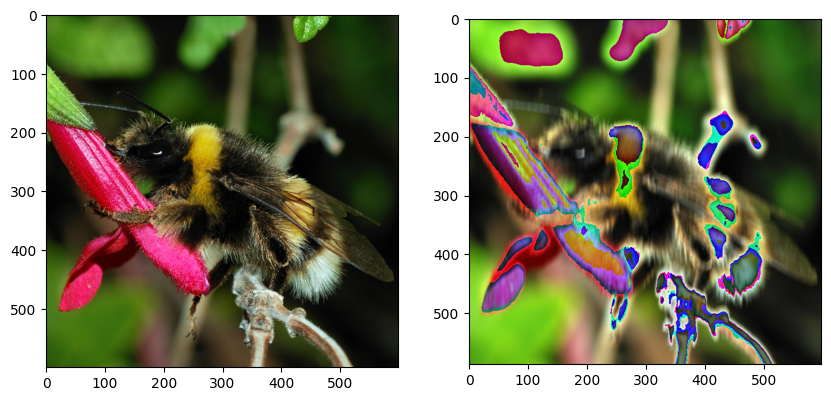

In [18]:
conv3 = Conv2D(filters=3, kernel_size=(15, 3), padding="valid",
           input_shape=(None, None, 3), kernel_initializer=my_kernel)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))

img_out = conv3(img_in)
np_img_out = img_out[0].numpy()
ax1.imshow(np_img_out.astype('uint8'));

### Working on edge detection on Grayscale image

Using a grayscale image, let's build an "edge detector" using a convolutional filter. Some filters pre-date the deep learning era and are still used today. For example, the Sobel filter is used to detect edges in images. These easy-to-compute filters were used in the early days of computer vision and are still useful now.

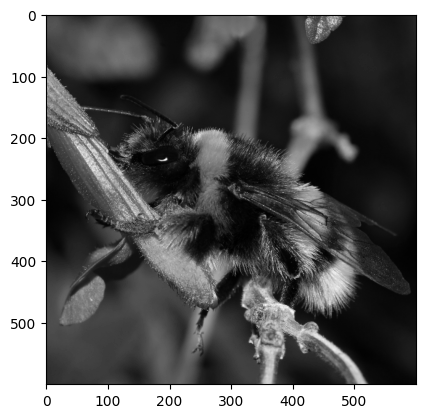

In [19]:
# convert image to greyscale
grey_sample_image = sample_image.mean(axis=2)

# add the channel dimension even if it's only one channel so
# to be consistent with Keras expectations.
grey_sample_image = grey_sample_image[:, :, np.newaxis]

# matplotlib does not like the extra dim for the color channel
# when plotting gray-level images. Let's use squeeze:
plt.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray);

**Exercise**
- Build an edge detector using `Conv2D` on greyscale image by defining the kernel inside `my_kernel`.
- You may experiment with several kernels to find a way to detect edges. The following article contains specific examples of kernels that you can use:
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- Try different kernels and see the impact on the output.

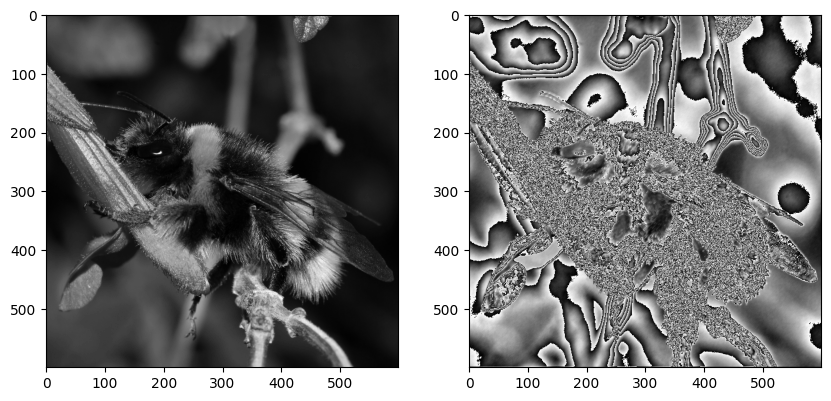

In [21]:
def my_kernel(shape=(3, 3, 1, 1), dtype=None):
    array = np.array([[1, 0, 5],
                      [0, 1, 0],
                      [2, 0, 1]]) # Replace with your kernel
    array = array.reshape(*shape) # Reshape if needed
    return array

conv = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
              input_shape=(None, None, 1), kernel_initializer=my_kernel)

img_in = np.expand_dims(grey_sample_image, 0) # Reshape into a batch of size 1
img_out = conv(img_in) # Apply the convolutional filter
np_img_out = img_out[0].numpy() # Convert to numpy array

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray)
ax1.imshow(np_img_out.astype(np.uint8), cmap=plt.cm.gray);


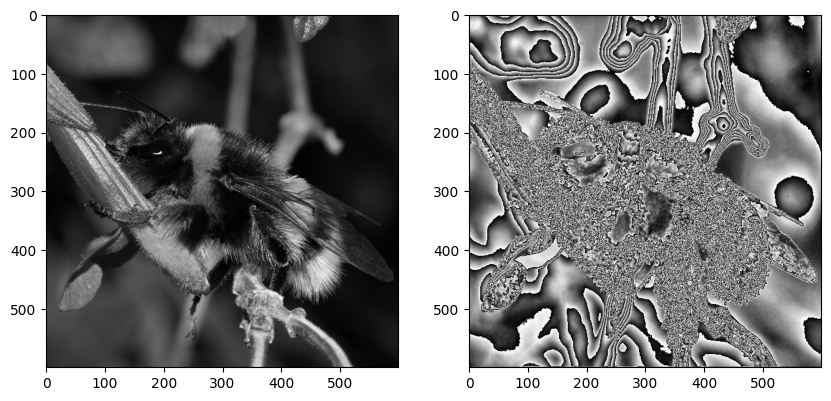

In [25]:
## Trying another

def my_kernel(shape=(3, 3, 1, 1), dtype=None):
    array = np.array([[2, 1, 2],
                      [1, 0, 1],
                      [2, 1, 2]]) # Replace with your kernel
    array = array.reshape(*shape) # Reshape if needed
    return array

conv = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
              input_shape=(None, None, 1), kernel_initializer=my_kernel)

img_in = np.expand_dims(grey_sample_image, 0) # Reshape into a batch of size 1
img_out = conv(img_in) # Apply the convolutional filter
np_img_out = img_out[0].numpy() # Convert to numpy array

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray)
ax1.imshow(np_img_out.astype(np.uint8), cmap=plt.cm.gray);

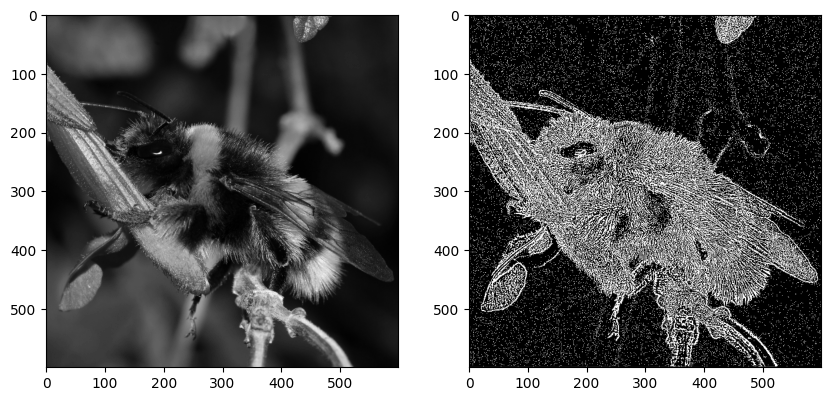

In [35]:
## Trying another

def my_kernel(shape=(3, 3, 1, 1), dtype=None):
    array = np.array([[-1/8, -1/8, -1/8],
                      [-1/8, 1, -1/8],
                      [-1/8, -1/8, -1/8]]) # Replace with your kernel
                      # The -1/8 means that only if there is a sharp change you see color, if gradual black
    array = array.reshape(*shape) # Reshape if needed
    return array

conv = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
              input_shape=(None, None, 1), kernel_initializer=my_kernel)

img_in = np.expand_dims(grey_sample_image, 0) # Reshape into a batch of size 1
img_out = conv(img_in) # Apply the convolutional filter
np_img_out = img_out[0].numpy() # Convert to numpy array

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray)
ax1.imshow(np_img_out.astype(np.uint8), cmap=plt.cm.gray);

### Pooling and strides with convolutions

**Exercise**
- Use `MaxPool2D` to apply a 2x2 max pool with strides 2 to the image. What is the impact on the shape of the image?
- Use `AvgPool2D` to apply an average pooling.
- Is it possible to compute a max pooling and an average pooling with well chosen kernels?

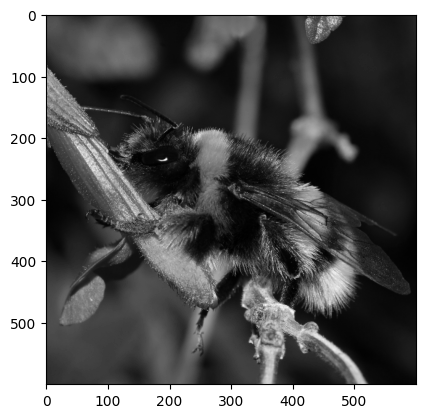

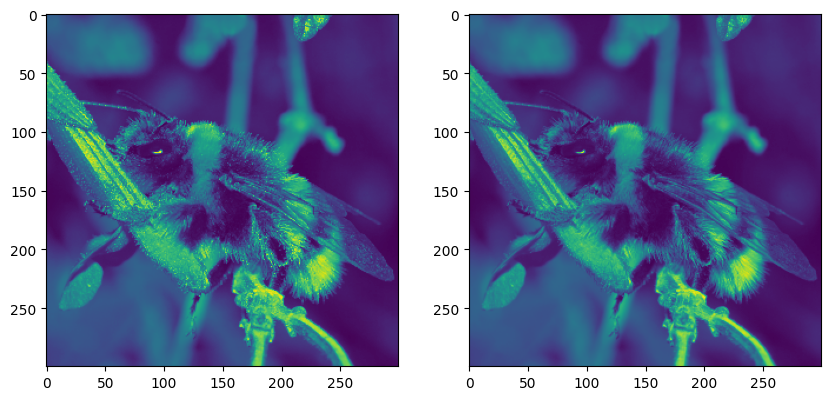

In [37]:
from tensorflow.keras.layers import MaxPool2D, AvgPool2D

# You can use `img_in` from above as input to the pooling layers

plt.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray);

max_pool = MaxPool2D(pool_size =(2,2), strides = 2)
average_pool = AvgPool2D(pool_size =(2,2), strides = 2)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(max_pool(img_in)[0].numpy().astype('uint8'))
ax1.imshow(average_pool(img_in)[0].numpy().astype('uint8'))

## Shows the same key things with less pixels

## Loading a JPEG file as a numpy array

Let's use [scikit-image](http://scikit-image.rg) to load the content of a JPEG file into a numpy array:

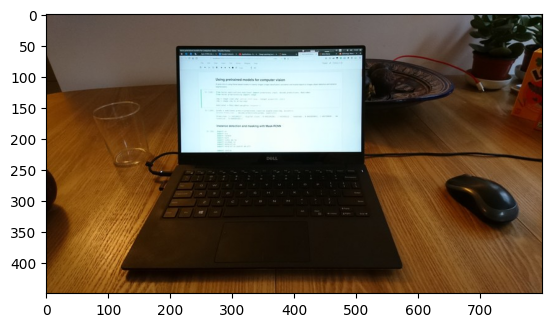

In [39]:
from skimage.io import imread

download_image('laptop.jpeg')
image = imread('laptop.jpeg')
plt.imshow(image);

## Resizing images, handling data types and dynamic ranges

While convolutions can handle inputs of any size, it is often useful to resize images to a fixed size. This is particularly important for training deep learning models:

- for **image classification**, most networks expect a specific **fixed input size**;

- for **object detection** and instance segmentation, networks have more flexibility but the image should have **approximately the same size as the training set images**.

Furthermore **large images can be much slower to process** than smaller images (the number of pixels varies quadratically with the height and width).

In [40]:
from skimage.transform import resize

lowres_image = resize(image, (50, 50), mode='reflect', anti_aliasing=True)
lowres_image.shape

(50, 50, 3)

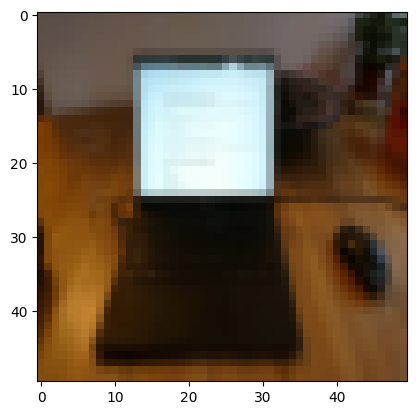

In [41]:
plt.imshow(lowres_image, interpolation='nearest');

The values of the pixels of the low resolution image are computed from by combining the values of the pixels in the high resolution image. The result is therefore represented as floating points.

## Using a pretrained model

Objectives:

- Load a pre-trained ResNet50 pre-trained model using Keras Zoo
- Use the model to classify an image
- Use the model to classify an image from the webcam

Let's start with loading ResNet50, a well-established method for image classification. The ResNet50 "application" takes two key parameters here: firstly, `include_top` indicates whether we want to include the last layer of the network (the classification layer) or not. Secondly, `weights` indicates whether we want to load the weights of a model that has been pre-trained on ImageNet or not.

In [42]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=True, weights='imagenet')
model.compile(optimizer='sgd', loss='categorical_crossentropy')

102967424/102967424 [==============================] - 3s 0us/step


In [43]:
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

### Classification of an image

**Exercise**
- Reshape the `laptop` image to the shape `(224, 224, 3)` using `resize` from `skimage.transform`
- Use `preprocess_input` from `tensorflow.keras.applications.imagenet_utils` to preprocess the image
- Use `predict` to classify the image

Documentation for each method:
- [resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize)
- [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input)
- [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

35363/35363 [==============================] - 0s 0us/step


[[('n03196217', 'digital_clock', 0.06576968),
  ('n06359193', 'web_site', 0.05700301),
  ('n03729826', 'matchstick', 0.051123265),
  ('n01930112', 'nematode', 0.0435351),
  ('n04404412', 'television', 0.030827746)]]

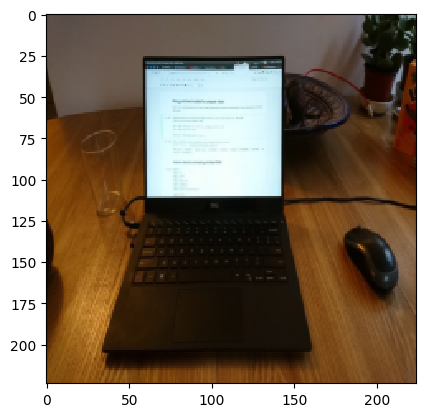

In [50]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# Your code here
midres_image = resize(image, (224, 224, 3), mode='reflect', anti_aliasing=True)
midres_image.shape
plt.imshow(midres_image, interpolation='nearest');

# preprocess the image
processed_image = preprocess_input(midres_image)
#processed_image = np.expand_dims(midres_image, 0)

# classify the image
predictions = model.predict(np.expand_dims(processed_image, axis=0))
decode_predictions(predictions)

## Fine-Tuning a Pretrained Model

Next, we will take our pre-trained model and fine-tune it on a new dataset. This is a common technique in deep learning, where we take a model that has been trained on a large dataset (like ImageNet) and then fine-tune it on a smaller dataset that is more specific to our task.

In [51]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

model = ResNet50(include_top=True, weights='imagenet')

# Freeze all layers except the last one
for layer in model.layers[:-1]:
    layer.trainable = False

# Print a summary of the model
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

The model that we've downloaded is trained on the ImageNet dataset, which takes in images of size 224x224x3 and predicts one of 1000 classes. We want to use the same model, but on a dataset of 32x32x3 images with 10 classes. To do this, we need to replace the last layer of the model with a new layer that has 10 output units and a softmax activation function, and resize our images to be 224x224x3.

In [52]:
# Load a dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train[:5000]
y_train = y_train[:5000]

x_test = x_test[:1000]
y_test = y_test[:1000]

# Preprocess the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

170498071/170498071 [==============================] - 6s 0us/step


In [53]:
# Replace the last layer of the model
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tqdm import tqdm

predictions = Dense(10, activation='softmax')(model.layers[-2].output)
model = keras.Model(inputs=model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [54]:
x_train = np.array([resize(x, (224, 224, 3)) for x in tqdm(x_train)])
x_test = np.array([resize(x, (224, 224, 3)) for x in tqdm(x_test)])

100%|██████████| 1000/1000 [00:12<00:00, 82.30it/s]


In [55]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_test, y_test))

157/157 [==============================] - 30s 150ms/step - loss: 0.6714 - accuracy: 0.7756 - val_loss: 0.4381 - val_accuracy: 0.8480


In [56]:
# Evaluate the model
model.evaluate(x_test, y_test)

32/32 [==============================] - 3s 93ms/step - loss: 0.4381 - accuracy: 0.8480


[0.43805617094039917, 0.8479999899864197]

In [61]:
# classify the image
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

32/32 [==============================] - 3s 91ms/step
[3 8 8 0 6 6 1 6 3 1 0 9 3 7 9 8 5 7 8 6 7 0 4 9 4 4 3 0 9 6 6 2 4 5 9 3 4
 9 9 5 0 6 5 6 0 9 3 9 7 6 9 8 7 3 8 8 7 3 3 3 7 3 6 3 6 2 1 2 3 7 2 3 8 8
 0 2 9 3 7 8 8 1 1 7 3 7 2 7 8 9 0 3 8 6 4 6 6 4 0 7 4 5 6 3 1 1 3 6 8 7 4
 0 2 2 1 3 0 4 6 7 8 3 1 2 8 0 8 3 3 2 4 1 8 9 1 2 9 7 2 1 6 5 6 3 8 7 6 5
 5 2 8 9 6 9 0 6 2 9 3 4 2 1 3 6 0 4 8 4 5 0 9 9 9 8 9 9 3 7 3 0 0 5 2 4 3
 8 6 3 3 8 5 8 0 1 7 4 8 8 7 8 5 1 8 9 1 3 0 5 7 9 5 4 5 9 8 0 7 9 8 2 7 6
 9 4 3 1 0 4 7 6 5 1 7 8 8 0 4 9 5 5 1 1 8 9 0 3 1 9 2 2 5 3 9 1 4 8 3 0 0
 1 8 1 5 7 0 8 2 4 7 0 2 3 6 3 8 3 1 3 4 3 9 0 6 1 0 9 1 8 7 9 1 2 6 1 3 4
 6 0 0 6 6 6 2 2 6 0 8 2 1 2 8 6 8 0 4 0 7 7 6 5 3 3 2 3 7 1 7 5 4 6 1 9 3
 6 6 9 3 8 0 7 2 6 0 5 8 5 4 6 8 9 1 1 8 2 2 4 3 2 8 0 9 5 8 1 9 4 1 3 8 1
 4 7 9 4 2 7 0 7 4 6 6 9 0 1 2 8 7 2 3 5 1 2 6 2 9 6 2 3 1 3 9 8 7 8 8 4 0
 1 8 2 7 3 3 6 1 9 6 7 2 7 4 5 8 0 2 9 6 4 0 6 2 5 3 7 3 7 2 3 3 1 1 4 9 9
 5 7 3 0 2 2 4 9 3 3 9 4 2 5 6 6 5 6 1 4 3 4 4